In [1]:
import pandas as pd
# From:
# https://gist.github.com/eljost/2c4e1af652ef02b2989da341c5569af7
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import scipy.stats as st
from sklearn import preprocessing
import zarr
import napari
from tqdm.auto import tqdm
from sklearn import preprocessing
from wbfm.utils.video_and_data_conversion.import_video_as_array import get_single_volume
from wbfm.utils.projects.utils_project import load_config
from pathlib import Path
from wbfm.utils.projects.utils_project import safe_cd
import cv2
from wbfm.utils.feature_detection.visualization_tracks import visualize_tracks
import open3d as o3d

In [2]:

%load_ext autoreload
%autoreload 2

project_path = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\project_config.yaml"
cfg = load_config(project_path)

red_btf = cfg['red_bigtiff_fname']
num_z = cfg['dataset_params']['num_slices']

In [3]:
# Get data
i_ref = 110
ref_frame = get_single_volume(red_btf, i_ref, num_z, 0.15)

i_test = 111
test_frame = get_single_volume(red_btf, i_test, num_z, 0.15)

In [4]:
# Remove background
background = 2*np.mean(ref_frame)
ref_frame = np.where(ref_frame>background, ref_frame, 0)
test_frame = np.where(test_frame>background, test_frame, 0)

In [5]:
# Get segmentation
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\reindexed_masks.zarr"
z = zarr.open(fname)

ref_seg = np.array(z[i_ref,...])
test_seg = np.array(z[i_test,...])

In [366]:
# Visualize
two_frames = np.stack([ref_frame, test_frame], axis=0)
two_seg = np.stack([ref_seg, test_seg], axis=0)

# viewer = napari.view_image(two_frames[:,15,...])
# viewer.add_labels(two_seg[:,15,...])
viewer = napari.view_image(two_frames)

In [6]:
# Get neuron matches
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\red_traces.h5"
df = pd.read_hdf(fname)

ref_zxy = []
test_zxy = []

neuron_names = df.columns.levels[0]
for name in tqdm(neuron_names):
    # Flip xy
    ref_zxy.append([df[name]['z_dlc'][i_ref], df[name]['y_dlc'][i_ref], df[name]['x_dlc'][i_ref]])
    test_zxy.append([df[name]['z_dlc'][i_test], df[name]['y_dlc'][i_test], df[name]['x_dlc'][i_test]])

# Remove nan values
to_keep = []
for m0, m1 in zip(ref_zxy, test_zxy):
    if any(np.isnan(m0)) or any(np.isnan(m1)):
        to_keep.append(False)
    else:
        to_keep.append(True)

ref_matches = np.array([zxy for keep, zxy in zip(to_keep, ref_zxy) if keep])
test_matches = np.array([zxy for keep, zxy in zip(to_keep, test_zxy) if keep])

print(f"Found {len(ref_matches)} matches out of {len(ref_zxy)} neurons")

  0%|          | 0/62 [00:00<?, ?it/s]

Found 20 matches out of 62 neurons


In [8]:
# Build an affine motion model
val, h_3d, inliers = cv2.estimateAffine3D(test_matches, ref_matches, confidence=0.99)
h_2d = h_3d[1:, 1:]

if h_3d is not None:
    # And translate ALL the neurons (not only matches)
    test_trans = cv2.transform(np.array([test_zxy]), h_3d)[0]
    
    rotated_frame = np.zeros_like(test_frame)
    for i, f in enumerate(test_frame):
#         out = np.zeros_like(f)
        sz = (f.shape[1], f.shape[0])
        out = cv2.warpAffine(f, h_2d, dsize=sz)
        rotated_frame[i,...] = out
    
    rotated_matches = cv2.transform(np.array([test_matches]), h_3d)[0]

In [369]:
# Visualize
# matches = [(i,i) for i in range(len(test_trans)) if to_keep[i]]

# # Remove nan values
# ref_tmp = np.where(~np.isnan(ref_zxy), np.array(ref_zxy), 0)
# trans_tmp = np.where(~np.isnan(test_trans), test_trans, 0)
# test_tmp = np.where(~np.isnan(test_zxy), test_zxy, 0)

# visualize_tracks(np.array(test_tmp), ref_tmp, matches)
# plt.figure(figsize=(45,15))
# diff = np.array(test_matches) - ref_matches
# plt.imshow(np.max(ref_frame, axis=0), alpha=0.5, cmap='Blues')
# # plt.imshow(np.max(test_frame, axis=0), alpha=0.5, cmap='Reds')
# plt.imshow(np.max(rotated_frame, axis=0), alpha=0.5, cmap='Greens')

In [370]:
# viewer = napari.view_image(ref_frame)
# viewer.add_image(rotated_frame)

In [67]:
# Build GP to get a flow field

diff = rotated_matches - ref_matches

scaler = preprocessing.StandardScaler().fit(ref_matches)
ref_matches_scaled = scaler.transform(ref_matches)

In [26]:

kernel = RBF(length_scale=2, length_scale_bounds=(1e-08, 100.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))
opt = {'n_restarts_optimizer':10, 'alpha':0.0}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(ref_matches_scaled[:,1:], diff[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(ref_matches_scaled[:,1:], diff[:,2])

x_predict, x_cov = gpx.predict(ref_matches_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(ref_matches_scaled[:,1:], return_cov=True)

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceW

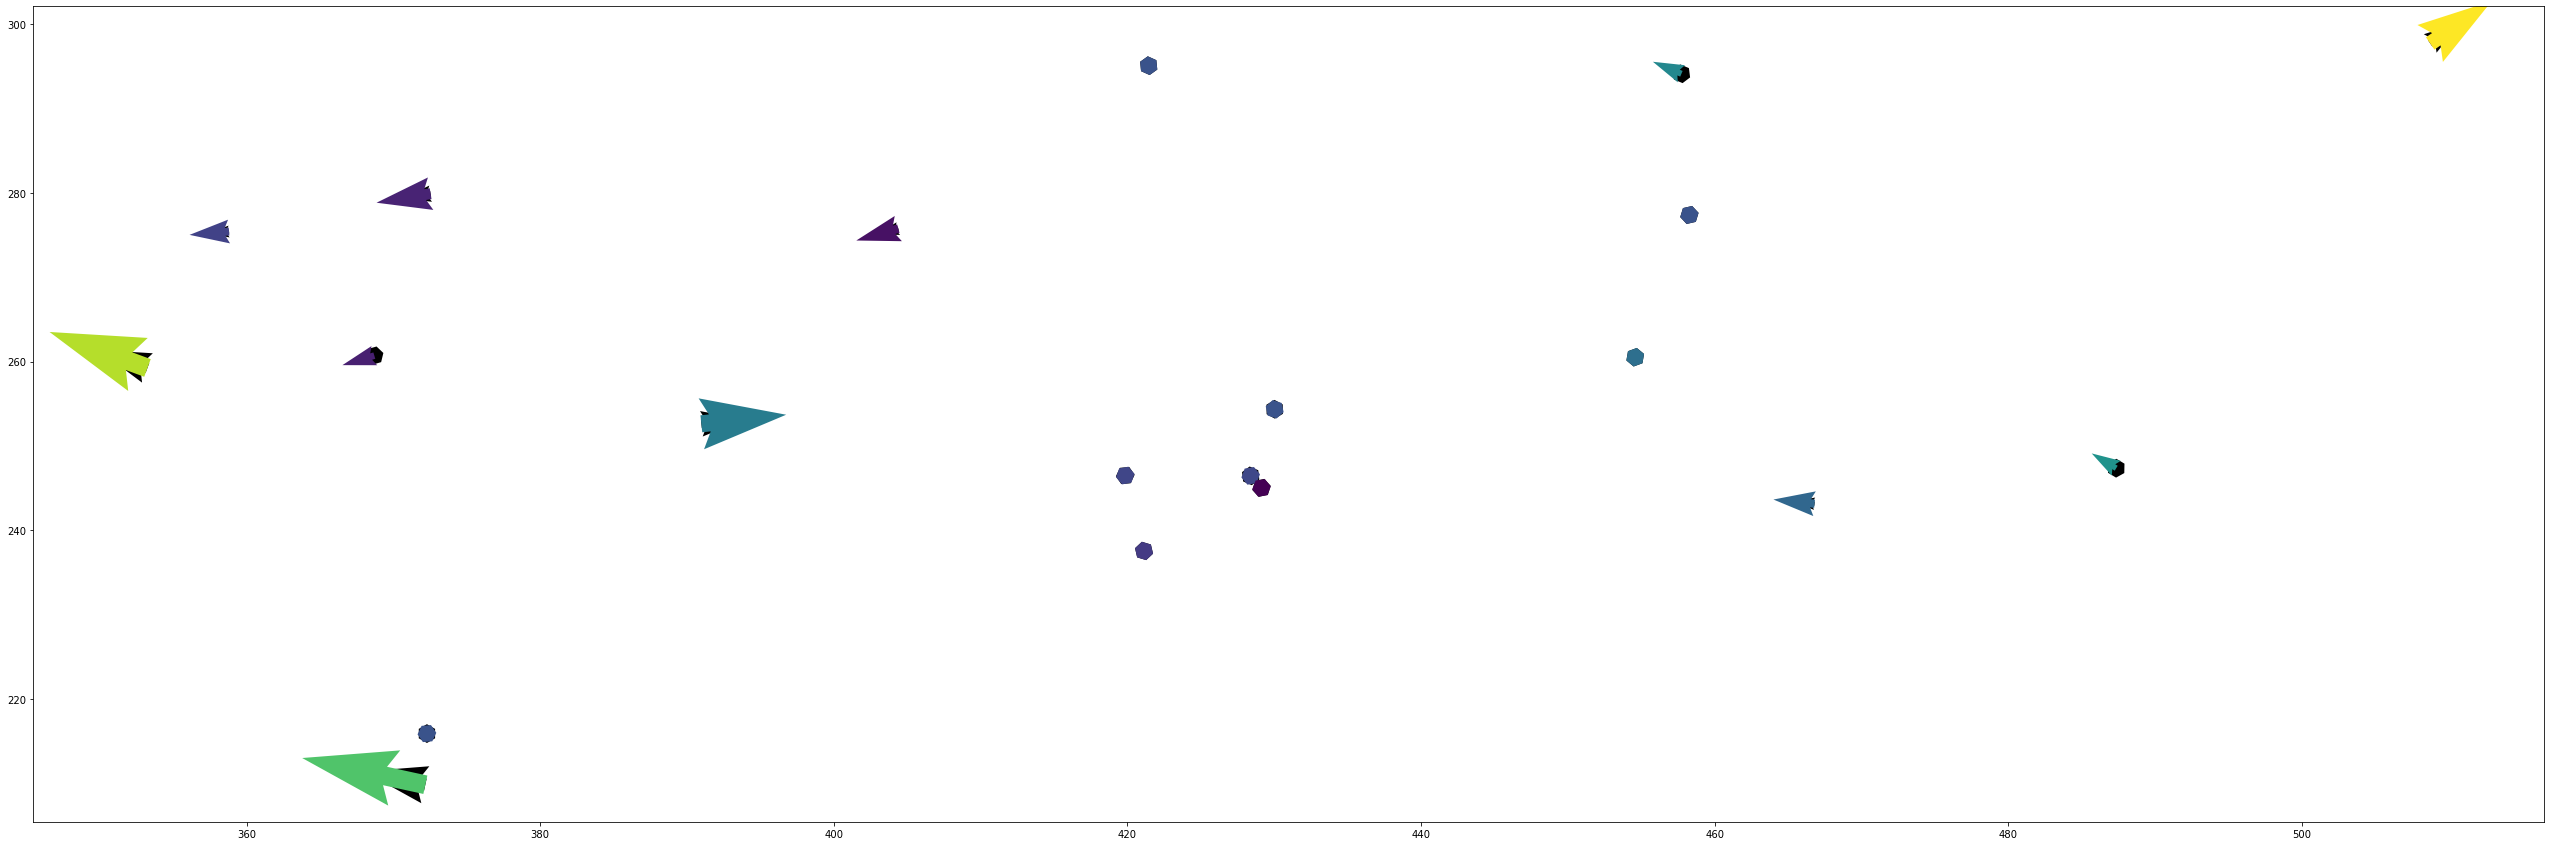

In [27]:
%matplotlib inline

plt.figure(figsize=(45,15))
opt = {'angles':'xy', 'scale_units':'xy', 'scale':1}
C = diff[:,2] / np.max(diff[:,1])
plt.quiver(ref_matches[:,1], ref_matches[:,2], x_predict, y_predict, **opt)
plt.quiver(ref_matches[:,1], ref_matches[:,2], diff[:,1], diff[:,2], C, **opt)

In [76]:
# Get dense GP predictions

x = np.arange(0,ref_frame.shape[1])
y = np.arange(0,ref_frame.shape[2])
xx, yy = np.meshgrid(x, y)
positions = np.vstack([xx.ravel(), yy.ravel()]).T
positions = [[15, p[0], p[1]] for p in positions]

x_predict = gpx.predict(scaler.transform(positions)[:,1:])
y_predict = gpy.predict(scaler.transform(positions)[:,1:])


In [77]:
gp_flow = np.zeros(ref_frame.shape[1:] + (2,), dtype='float32')
for i, p in enumerate(positions):
    gp_flow[p[0], p[1], :] = [x_predict[i], y_predict[i]]

In [78]:
i_slice = 15
gp_warped = warp_flow(rotated_frame[i_slice,...], gp_flow)

Text(0.5, 1.0, 'Overlay after affine + GP transformation')

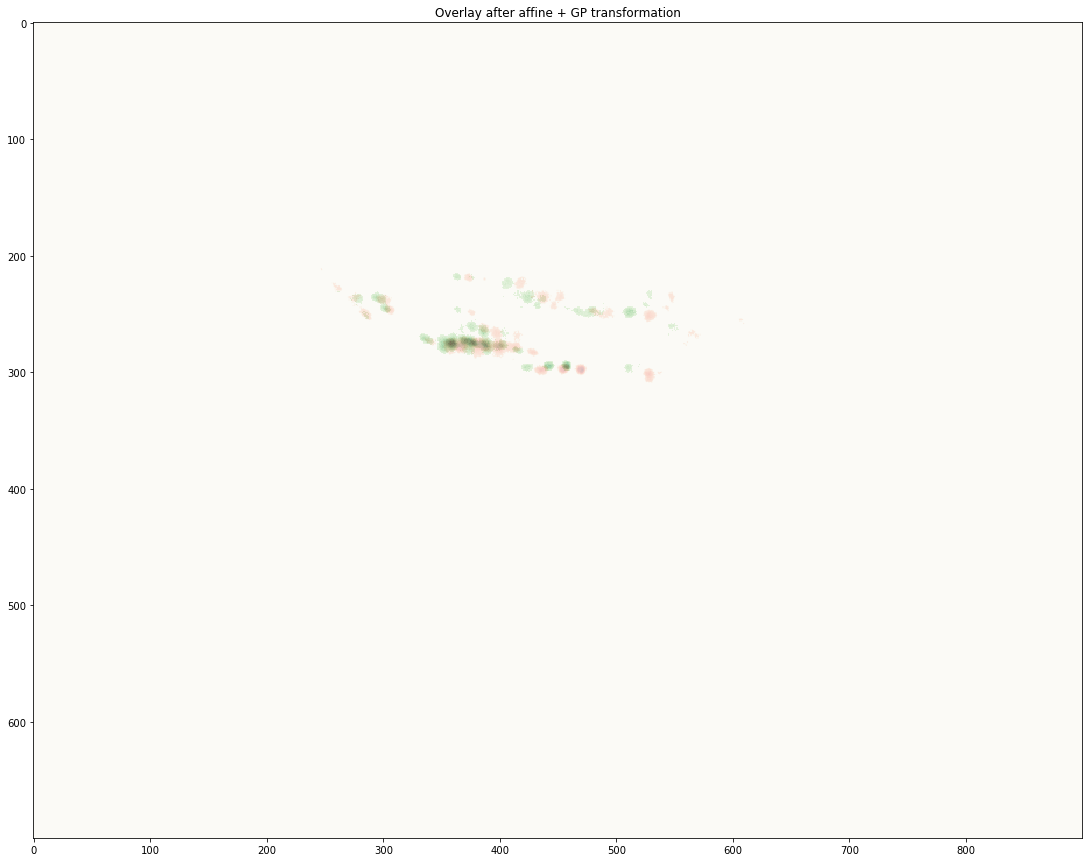

In [90]:
plt.figure(figsize=(45,15))
plt.imshow(gp_warped, alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after affine + GP transformation")

In [12]:
# Finalize using classical optical flow
def warp_flow(img, flow):
    # From:
    # https://github.com/opencv/opencv/blob/master/samples/python/opt_flow.py#L50-L56
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

def calc_optical_flow(start, target, i_slice):
    flow = cv2.calcOpticalFlowFarneback(rotated_frame[i_slice,...], ref_frame[i_slice,...], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    warped_img = warp_flow(rotated_frame[i_slice,...], flow)
    return flow, warped_img

In [88]:
def visualize_flow(flow):
    hsv = np.zeros(gp_flow.shape[:-1] + (3,), dtype='uint8')
    hsv[...,1] = 0

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    # Remove spurious angles
#     mask = np.logical_or(ref_frame[15,...]>0, rotated_frame[15,...]>0)
#     for i in range(hsv.shape[-1]):
#         hsv[...,i] = np.where(mask, hsv[...,i], 0)

    bgr = cv2.cvtColor(hsv,code=cv2.COLOR_HSV2BGR)

    plt.figure(figsize=(45,15))
#     plt.imshow(hsv[...,0], cmap='Reds', alpha=0.5)
#     plt.imshow(hsv[...,2], cmap='Blues', alpha=0.5)
    plt.imshow(hsv)
    plt.colorbar()
    return hsv

In [91]:
# hsv = visualize_flow(gp_flow);

In [92]:
flow, warped = calc_optical_flow(rotated_frame, ref_frame, 15)

In [95]:
# i_slice = 15

# plt.figure(figsize=(45,15))
# plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Reds")
# plt.imshow(rotated_frame[i_slice,...], alpha=0.5, cmap="Greens")
# plt.title("Overlay after affine transformation")

Text(0.5, 1.0, 'Overlay after affine transformation + optical flow')

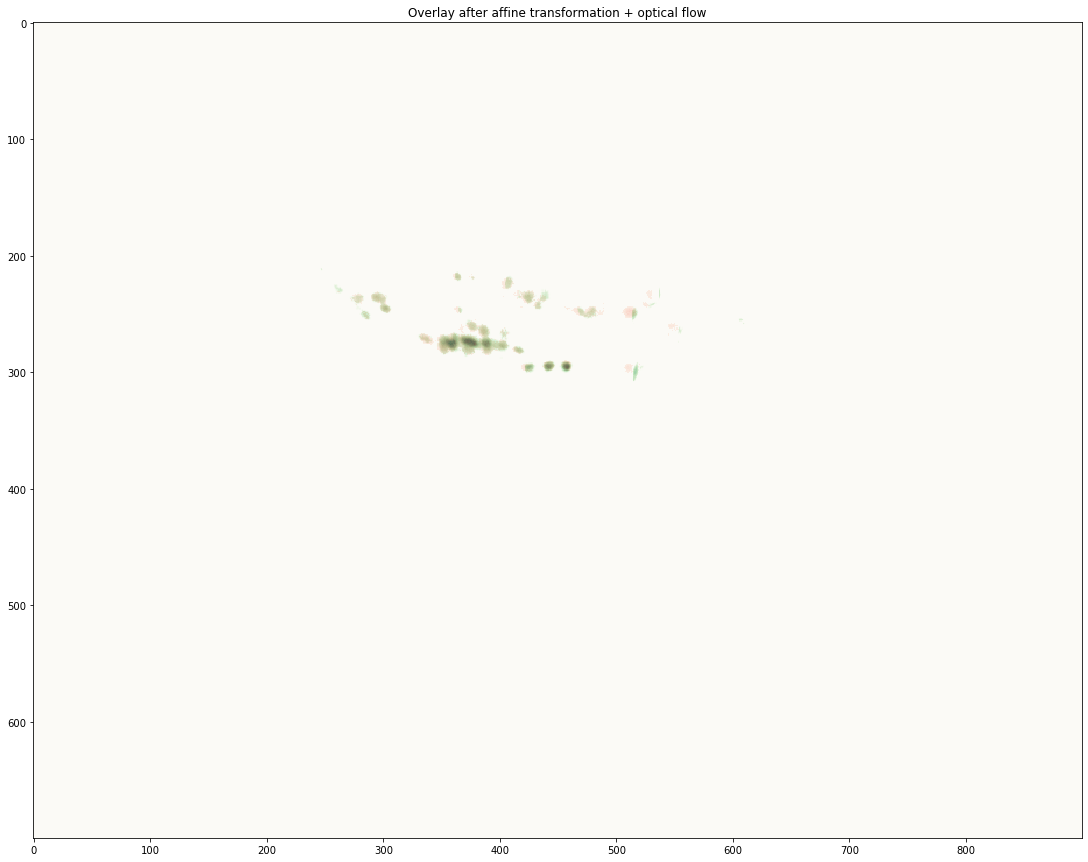

In [94]:
i_slice = 15

flow, warped = calc_optical_flow(rotated_frame, ref_frame, i_slice)

plt.figure(figsize=(45,15))
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(warped, alpha=0.5, cmap="Greens")
plt.title("Overlay after affine transformation + optical flow")

In [ ]:
# Try to use keypoint flow, then interpolate via GP

In [104]:
# Data
i_slice = 15
rotated_slice, ref_slice = rotated_frame[15,...], ref_frame[15,...]

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (25,25),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 7 )

p0 = cv2.goodFeaturesToTrack(ref_slice, mask = None, **feature_params)
p1, st, err = cv2.calcOpticalFlowPyrLK(ref_slice, rotated_slice, p0, None, **lk_params)

p0, p1 = np.squeeze(p0), np.squeeze(p1)

IndexError: pop from empty list

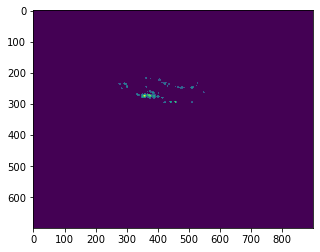

In [106]:
plt.imshow(rotated_slice)
plt.imshow(ref_slice)
plt.quiver(p0-p1)
# for i0, i1 in zip(p0, p1):
    

In [105]:
p0

array([[458., 295.],
       [440., 295.],
       [381., 276.],
       [359., 276.],
       [334., 269.],
       [304., 247.],
       [363., 218.],
       [432., 243.],
       [404., 277.],
       [292., 235.],
       [511., 295.],
       [341., 273.],
       [380., 266.],
       [364., 246.],
       [421., 296.],
       [387., 270.],
       [365., 271.],
       [509., 248.],
       [350., 271.],
       [372., 259.],
       [413., 280.],
       [299., 241.]], dtype=float32)